# Recepie Review and User Feedback Dataset

# CRIPS - DM Methodology
 1. Bussiness Understanding.
 2. Data Understanding. 
 3. Data Preparation.
 4. Modelling. 
 5. Evaluation. 
 6. Deplotment.

#### 1.Bussiness Understanding


- Recepies names information.
- The recepies has ranking on the top 100 best.
- Internal user reputation score (might have different weights based on their reputation)
- Comments has unique ID (most import up-votes).
- qualify sentimen 1 to 5 / 0 denoting absence of rating

- Bussiness can develop recomender systems 
- Bussiness can develop behavior analysis 

### 2.Data Understanding

In [19]:
# Cell 1: Project Setup and Imports
import numpy as np
import pandas as pd
import torch
from typing import Dict, List, Tuple, Any
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import json
import re
from tqdm.auto import tqdm

# NLTK for VADER
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

# Configure plotting style
sns.set_palette("husl")

# Suppress warnings
warnings.filterwarnings('ignore')

# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU Name: NVIDIA GeForce RTX 2070 SUPER


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\geova\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [23]:
# Cell 2: Project Configuration
class Config:
    """Configuration settings for the sentiment analysis project."""
    
    # Project paths
    DATA_RAW: str = "../data/raw/Recipe Reviews and User Feedback Dataset.csv"
    DATA_PROCESSED: str = "../data/processed/Task_3/"
    MODELS_PATH: str = "../models/Task_3/"
    FIGURES_PATH: str = "../reports/figures/Task_3/"
    EVAL_PATH: str = "../reports/model_evaluations/Task_3/"
    
    # Data settings
    RANDOM_SEED: int = 98
    MAX_LENGTH: int = 512
    BATCH_SIZE: int = 16
    VALIDATION_SPLIT: float = 0.2
    TEST_SPLIT: float = 0.1
             
    def _set_seeds(self) -> None:
        """Set random seeds for reproducibility."""
        np.random.seed(self.RANDOM_SEED)
        torch.manual_seed(self.RANDOM_SEED)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(self.RANDOM_SEED)

# Initialize configuration
config = Config()

In [24]:
# Cell 3: Initial Data Loading
def load_dataset(config: Config) -> pd.DataFrame:
    """
    Load the raw dataset and perform basic validation.
    
    Args:
        config: Project configuration object
    
    Returns:
        DataFrame containing the raw data
    """
    # Load data
    df = pd.read_csv(config.DATA_RAW)
    
    # Display basic information
    print("Dataset Overview:")
    print("-" * 50)
    print(f"Number of reviews: {len(df)}")
    print(f"Number of features: {len(df.columns)}")
    print("\nFeatures:")
    for col in df.columns:
        print(f"- {col}: {df[col].dtype}")
    
    print("\nMissing Values:")
    print(df.isnull().sum())
    
    return df

# Load initial dataset
df = load_dataset(config)

Dataset Overview:
--------------------------------------------------
Number of reviews: 18182
Number of features: 15

Features:
- Unnamed: 0: int64
- recipe_number: int64
- recipe_code: int64
- recipe_name: object
- comment_id: object
- user_id: object
- user_name: object
- user_reputation: int64
- created_at: int64
- reply_count: int64
- thumbs_up: int64
- thumbs_down: int64
- stars: int64
- best_score: int64
- text: object

Missing Values:
Unnamed: 0         0
recipe_number      0
recipe_code        0
recipe_name        0
comment_id         0
user_id            0
user_name          0
user_reputation    0
created_at         0
reply_count        0
thumbs_up          0
thumbs_down        0
stars              0
best_score         0
text               2
dtype: int64


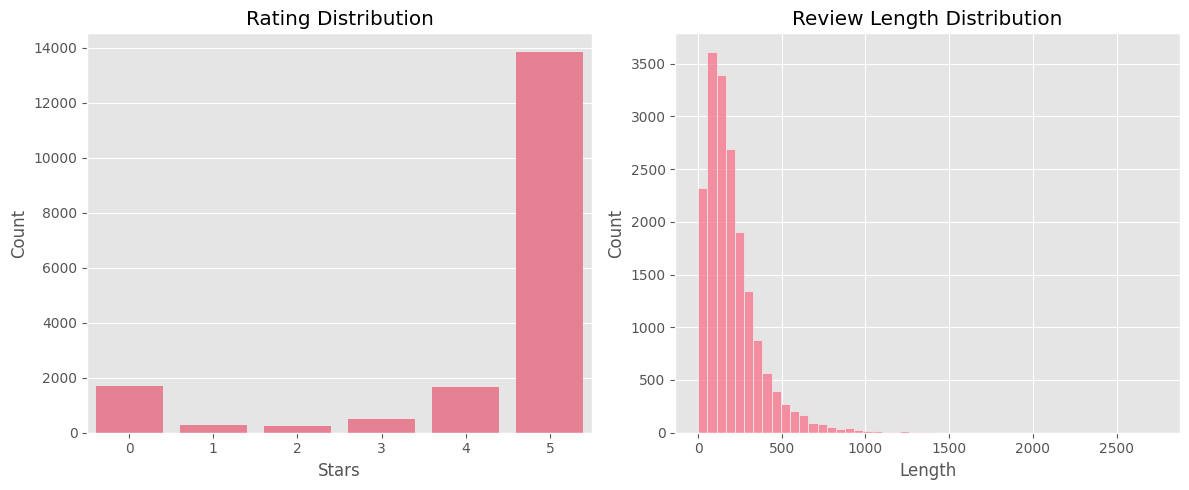


Rating Summary:
stars
0     1696
1      280
2      232
3      490
4     1655
5    13829
Name: count, dtype: int64

Text Length Summary:
count    18180.000000
mean       203.916337
std        172.469209
min          1.000000
25%         90.000000
50%        161.000000
75%        266.000000
max       2742.000000
Name: text_length, dtype: float64


In [25]:
# Cell 4: Basic Data Exploration
def explore_data(df: pd.DataFrame, config: Config) -> None:
    """
    Perform initial data exploration and create visualizations.
    
    Args:
        df: Input DataFrame
        config: Project configuration object
    """
    # Rating distribution
    plt.figure(figsize=(12, 5))
    
    # Stars distribution
    plt.subplot(1, 2, 1)
    sns.countplot(data=df, x='stars')
    plt.title('Rating Distribution')
    plt.xlabel('Stars')
    plt.ylabel('Count')
    
    # Save distribution plot
    plt.savefig(f"{config.FIGURES_PATH}rating_distribution.png")
    
    # Review length distribution
    plt.subplot(1, 2, 2)
    df['text_length'] = df['text'].str.len()
    sns.histplot(data=df, x='text_length', bins=50)
    plt.title('Review Length Distribution')
    plt.xlabel('Length')
    plt.ylabel('Count')
    
    plt.tight_layout()
    plt.savefig(f"{config.FIGURES_PATH}text_length_distribution.png")
    plt.show()
    
    # Print summary statistics
    print("\nRating Summary:")
    print(df['stars'].value_counts().sort_index())
    
    print("\nText Length Summary:")
    print(df['text_length'].describe())

# Explore data
explore_data(df, config)

In [3]:
# Load dataset
df = pd.read_csv("../data/raw/Recipe Reviews and User Feedback Dataset.csv")

# Display basic information
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
display(df.head())
print("\nLast few rows:")
display(df.tail())

Dataset Shape: (18182, 15)

First few rows:


,Unnamed: 0,recipe_number,recipe_code,recipe_name,comment_id,user_id,user_name,user_reputation,created_at,reply_count,thumbs_up,thumbs_down,stars,best_score,text
0,0,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2G3aneMRgRMZwXqIHmSdXSG1hEM,u_9iFLIhMa8QaG,Jeri326,1,1665619889,0,0,0,5,527,"I tweaked it a little, removed onions because ..."
1,1,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FsPC83HtzCsQAtOxlbL6RcaPbY,u_Lu6p25tmE77j,Mark467,50,1665277687,0,7,0,5,724,Bush used to have a white chili bean and it ma...
2,2,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FPrSGyTv7PQkZq37j92r9mYGkP,u_s0LwgpZ8Jsqq,Barbara566,10,1664404557,0,3,0,5,710,I have a very complicated white chicken chili ...
3,3,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2DzdSIgV9qNiuBaLoZ7JQaartoC,u_fqrybAdYjgjG,jeansch123,1,1661787808,2,2,0,0,581,"In your introduction, you mentioned cream chee..."
4,4,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2DtZJuRQYeTFwXBoZRfRhBPEXjI,u_XXWKwVhKZD69,camper77,10,1664913823,1,7,0,0,820,Wonderful! I made this for a &#34;Chili/Stew&#...



Last few rows:


,Unnamed: 0,recipe_number,recipe_code,recipe_name,comment_id,user_id,user_name,user_reputation,created_at,reply_count,thumbs_up,thumbs_down,stars,best_score,text
18177,114,100,82745,Mamaw Emily’s Strawberry Cake,sp_aUSaElGf_82745_c_331352,u_1oKblS4ULpTAACUTILo0QlO5mrN,WhittierCA,1,1622717977,0,0,0,5,100,This Strawberry Cake has been a family favorit...
18178,115,100,82745,Mamaw Emily’s Strawberry Cake,sp_aUSaElGf_82745_c_204836,u_1oKY7CKLaFQpI3cBCVaxHXAEGbt,susieswan,1,1613036720,0,0,0,5,100,<p>I received endless compliments on this cake...
18179,116,100,82745,Mamaw Emily’s Strawberry Cake,sp_aUSaElGf_82745_c_301178,u_1oKXBAuHbMDi9nnriVAbJoPqpeQ,blajr,1,1622717844,0,0,0,5,100,This cake was delicious and so moist! I didn&#...
18180,117,100,82745,Mamaw Emily’s Strawberry Cake,sp_aUSaElGf_82745_c_180512,u_1oKVbnueXfnlmYWuYH8xJ0mFxNQ,cafritz,1,1622717233,0,0,0,5,100,I just made this too. It is wonderful. As fo...
18181,118,100,82745,Mamaw Emily’s Strawberry Cake,sp_aUSaElGf_82745_c_262637,u_1oKW6W12cOLxiMzjA7j8nTqwFWG,nopalito,1,1622717625,0,1,0,5,193,"OMG, you must make this cake. I made it for my..."


### 3. Data Preparation
#### 3.1 Text Preprocessing
- Remove HTML tags
- Handle missing values
- Clean text (remove special characters, links)
- Basic text normalization

#### 3.2 Text Quality Analysis
- Review length distribution
- Language detection
- Text quality metrics
- Review completeness

#### 3.3 Feature Engineering
- Text length features
- Rating normalization
- Temporal features from created_at
- User reputation features

In [26]:
# Cell 5: Text Preprocessing Functions
def clean_text(text: str) -> str:
    """
    Clean and normalize text data.
    
    Args:
        text: Input text string
    
    Returns:
        Cleaned text string
    """
    if pd.isna(text):
        return ""
    
    # Convert to string and lowercase
    text = str(text).lower()
    
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove special characters and digits
    text = re.sub(r'[^\w\s]', '', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text

def analyze_text_quality(text: str) -> Dict[str, Any]:
    """
    Analyze the quality of text content.
    
    Args:
        text: Input text string
    
    Returns:
        Dictionary containing text quality metrics
    """
    if pd.isna(text):
        return {
            'length': 0,
            'word_count': 0,
            'avg_word_length': 0,
            'has_content': False
        }
    
    words = text.split()
    
    return {
        'length': len(text),
        'word_count': len(words),
        'avg_word_length': np.mean([len(w) for w in words]) if words else 0,
        'has_content': len(text.strip()) > 0
    }

In [28]:
# Cell 5: Import tqdm for pandas
from tqdm.auto import tqdm
tqdm.pandas()  # This enables progress_apply

# Cell 6: Apply Text Preprocessing
def preprocess_dataset(df: pd.DataFrame, config: Config) -> pd.DataFrame:
    """
    Preprocess the entire dataset.
    
    Args:
        df: Input DataFrame
        config: Project configuration object
    
    Returns:
        Preprocessed DataFrame
    """
    print("Starting data preprocessing...")
    
    # Create copy of DataFrame
    df_processed = df.copy()
    
    # Clean text
    print("Cleaning review text...")
    with tqdm(total=len(df_processed)) as pbar:
        df_processed['cleaned_text'] = df_processed['text'].apply(
            lambda x: clean_text(x)
        )
        pbar.update(1)
    
    # Extract text quality features
    print("Extracting text quality features...")
    quality_metrics = []
    with tqdm(total=len(df_processed)) as pbar:
        for text in df_processed['cleaned_text']:
            quality_metrics.append(analyze_text_quality(text))
            pbar.update(1)
    
    # Convert quality metrics to DataFrame
    quality_df = pd.DataFrame(quality_metrics)
    
    # Add quality features to DataFrame
    df_processed['text_length'] = quality_df['length']
    df_processed['word_count'] = quality_df['word_count']
    df_processed['avg_word_length'] = quality_df['avg_word_length']
    df_processed['has_content'] = quality_df['has_content']
    
    # Save preprocessed data
    preprocessed_path = f"{config.DATA_PROCESSED}preprocessed_data.csv"
    df_processed.to_csv(preprocessed_path, index=False)
    print(f"Saved preprocessed data to {preprocessed_path}")
    
    return df_processed

In [34]:
# Cell 6: Text Preprocessing
def preprocess_dataset(df: pd.DataFrame, config: Config) -> pd.DataFrame:
    """
    Preprocess the entire dataset.
    
    Args:
        df: Input DataFrame
        config: Project configuration object
    
    Returns:
        Preprocessed DataFrame
    """
    print("Starting data preprocessing...")
    
    # Create copy of DataFrame
    df_processed = df.copy()
    
    # Clean text
    print("Cleaning review text...")
    df_processed['cleaned_text'] = df_processed['text'].apply(clean_text)
    
    # Extract text quality features
    print("Extracting text quality features...")
    quality_metrics = df_processed['cleaned_text'].apply(analyze_text_quality)
    
    # Add quality features to DataFrame
    df_processed['text_length'] = quality_metrics.apply(lambda x: x['length'])
    df_processed['word_count'] = quality_metrics.apply(lambda x: x['word_count'])
    df_processed['avg_word_length'] = quality_metrics.apply(lambda x: x['avg_word_length'])
    df_processed['has_content'] = quality_metrics.apply(lambda x: x['has_content'])
    
    # Save preprocessed data
    preprocessed_path = f"{config.DATA_PROCESSED}preprocessed_data.csv"
    df_processed.to_csv(preprocessed_path, index=False)
    print(f"Saved preprocessed data to {preprocessed_path}")
    
    return df_processed

# Apply preprocessing
print("Starting preprocessing pipeline...")
df_processed = preprocess_dataset(df, config)
print("\nPreprocessing Statistics:")
print(f"Total reviews: {len(df_processed)}")
print(f"Reviews with content: {df_processed['has_content'].sum()}")

Starting preprocessing pipeline...
Starting data preprocessing...
Cleaning review text...
Extracting text quality features...
Saved preprocessed data to ../data/processed/Task_3/preprocessed_data.csv

Preprocessing Statistics:
Total reviews: 18182
Reviews with content: 18164


### 3.4 Feature Engineering
#### 3.4.1 Feature Creation
- Text features (length, word count, average word length)
- User features (reputation analysis)
- Temporal features from created_at
- Rating features (normalized ratings)

#### 3.4.2 Feature Analysis
- Distribution of engineered features
- Correlation analysis
- Feature importance assessment

In [36]:
# Cell 7: Apply Feature Engineering
def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Apply all feature engineering steps.
    
    Args:
        df: Input DataFrame
        
    Returns:
        DataFrame with all engineered features
    """
    print("Starting feature engineering...")
    
    # Apply each feature engineering step
    df_engineered = df.pipe(create_text_features)\
                     .pipe(create_user_features)\
                     .pipe(create_temporal_features)
    
    # Save engineered features
    engineered_path = f"{config.DATA_PROCESSED}engineered_features.csv"
    df_engineered.to_csv(engineered_path, index=False)
    print(f"Saved engineered features to {engineered_path}")
    
    return df_engineered

# Apply feature engineering
print("Starting feature engineering pipeline...")
df_engineered = engineer_features(df_processed)
print("\nFeature Engineering Statistics:")
print(f"Total features: {len(df_engineered.columns)}")
print("\nNew features added:")
for col in df_engineered.columns:
    if col not in df.columns:
        print(f"- {col}")

Starting feature engineering pipeline...
Starting feature engineering...
Saved engineered features to ../data/processed/Task_3/engineered_features.csv

Feature Engineering Statistics:
Total features: 30

New features added:
- cleaned_text
- word_count
- avg_word_length
- has_content
- sentences
- words_per_sentence
- normalized_length
- reputation_score
- engagement_score
- has_replies
- year
- month
- day_of_week
- is_weekend


In [37]:
# Cell 8: Feature Engineering Functions
def create_text_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create advanced text-based features.
    
    Args:
        df: Input DataFrame with cleaned text
    
    Returns:
        DataFrame with additional text features
    """
    df_features = df.copy()
    
    # Text complexity features
    df_features['sentences'] = df_features['cleaned_text'].apply(lambda x: len(str(x).split('.')))
    df_features['words_per_sentence'] = df_features['word_count'] / df_features['sentences']
    df_features['words_per_sentence'] = df_features['words_per_sentence'].fillna(0)
    
    # Normalize text length features
    df_features['normalized_length'] = (df_features['text_length'] - 
                                      df_features['text_length'].mean()) / df_features['text_length'].std()
    
    return df_features

def create_user_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create user-based features.
    
    Args:
        df: Input DataFrame
        
    Returns:
        DataFrame with additional user features
    """
    df_features = df.copy()
    
    # User reputation features
    df_features['reputation_score'] = (df_features['user_reputation'] - 
                                     df_features['user_reputation'].min()) / (
                                     df_features['user_reputation'].max() - 
                                     df_features['user_reputation'].min())
    
    # Interaction features
    df_features['engagement_score'] = df_features['thumbs_up'] - df_features['thumbs_down']
    df_features['has_replies'] = df_features['reply_count'] > 0
    
    return df_features

def create_temporal_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create time-based features from created_at.
    
    Args:
        df: Input DataFrame
        
    Returns:
        DataFrame with additional temporal features
    """
    df_features = df.copy()
    
    # Convert created_at to datetime
    df_features['created_at'] = pd.to_datetime(df_features['created_at'])
    
    # Extract temporal features
    df_features['year'] = df_features['created_at'].dt.year
    df_features['month'] = df_features['created_at'].dt.month
    df_features['day_of_week'] = df_features['created_at'].dt.dayofweek
    df_features['is_weekend'] = df_features['day_of_week'].isin([5, 6])
    
    return df_features

In [38]:
# Cell 9: Apply Feature Engineering
def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Apply all feature engineering steps.
    
    Args:
        df: Input DataFrame
        
    Returns:
        DataFrame with all engineered features
    """
    print("Starting feature engineering...")
    
    # Apply each feature engineering step
    df_engineered = df.pipe(create_text_features)\
                     .pipe(create_user_features)\
                     .pipe(create_temporal_features)
    
    # Save engineered features
    engineered_path = f"{config.DATA_PROCESSED}engineered_features.csv"
    df_engineered.to_csv(engineered_path, index=False)
    print(f"Saved engineered features to {engineered_path}")
    
    return df_engineered

# Apply feature engineering
df_engineered = engineer_features(df_processed)

Starting feature engineering...
Saved engineered features to ../data/processed/Task_3/engineered_features.csv


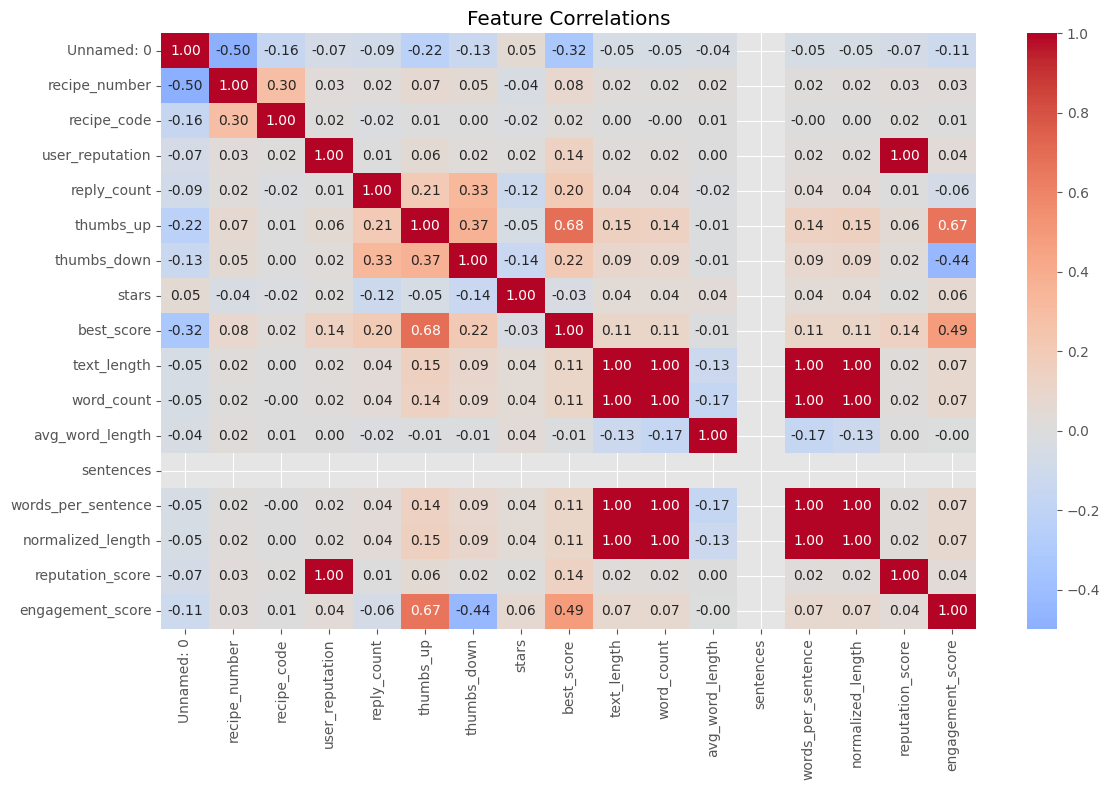

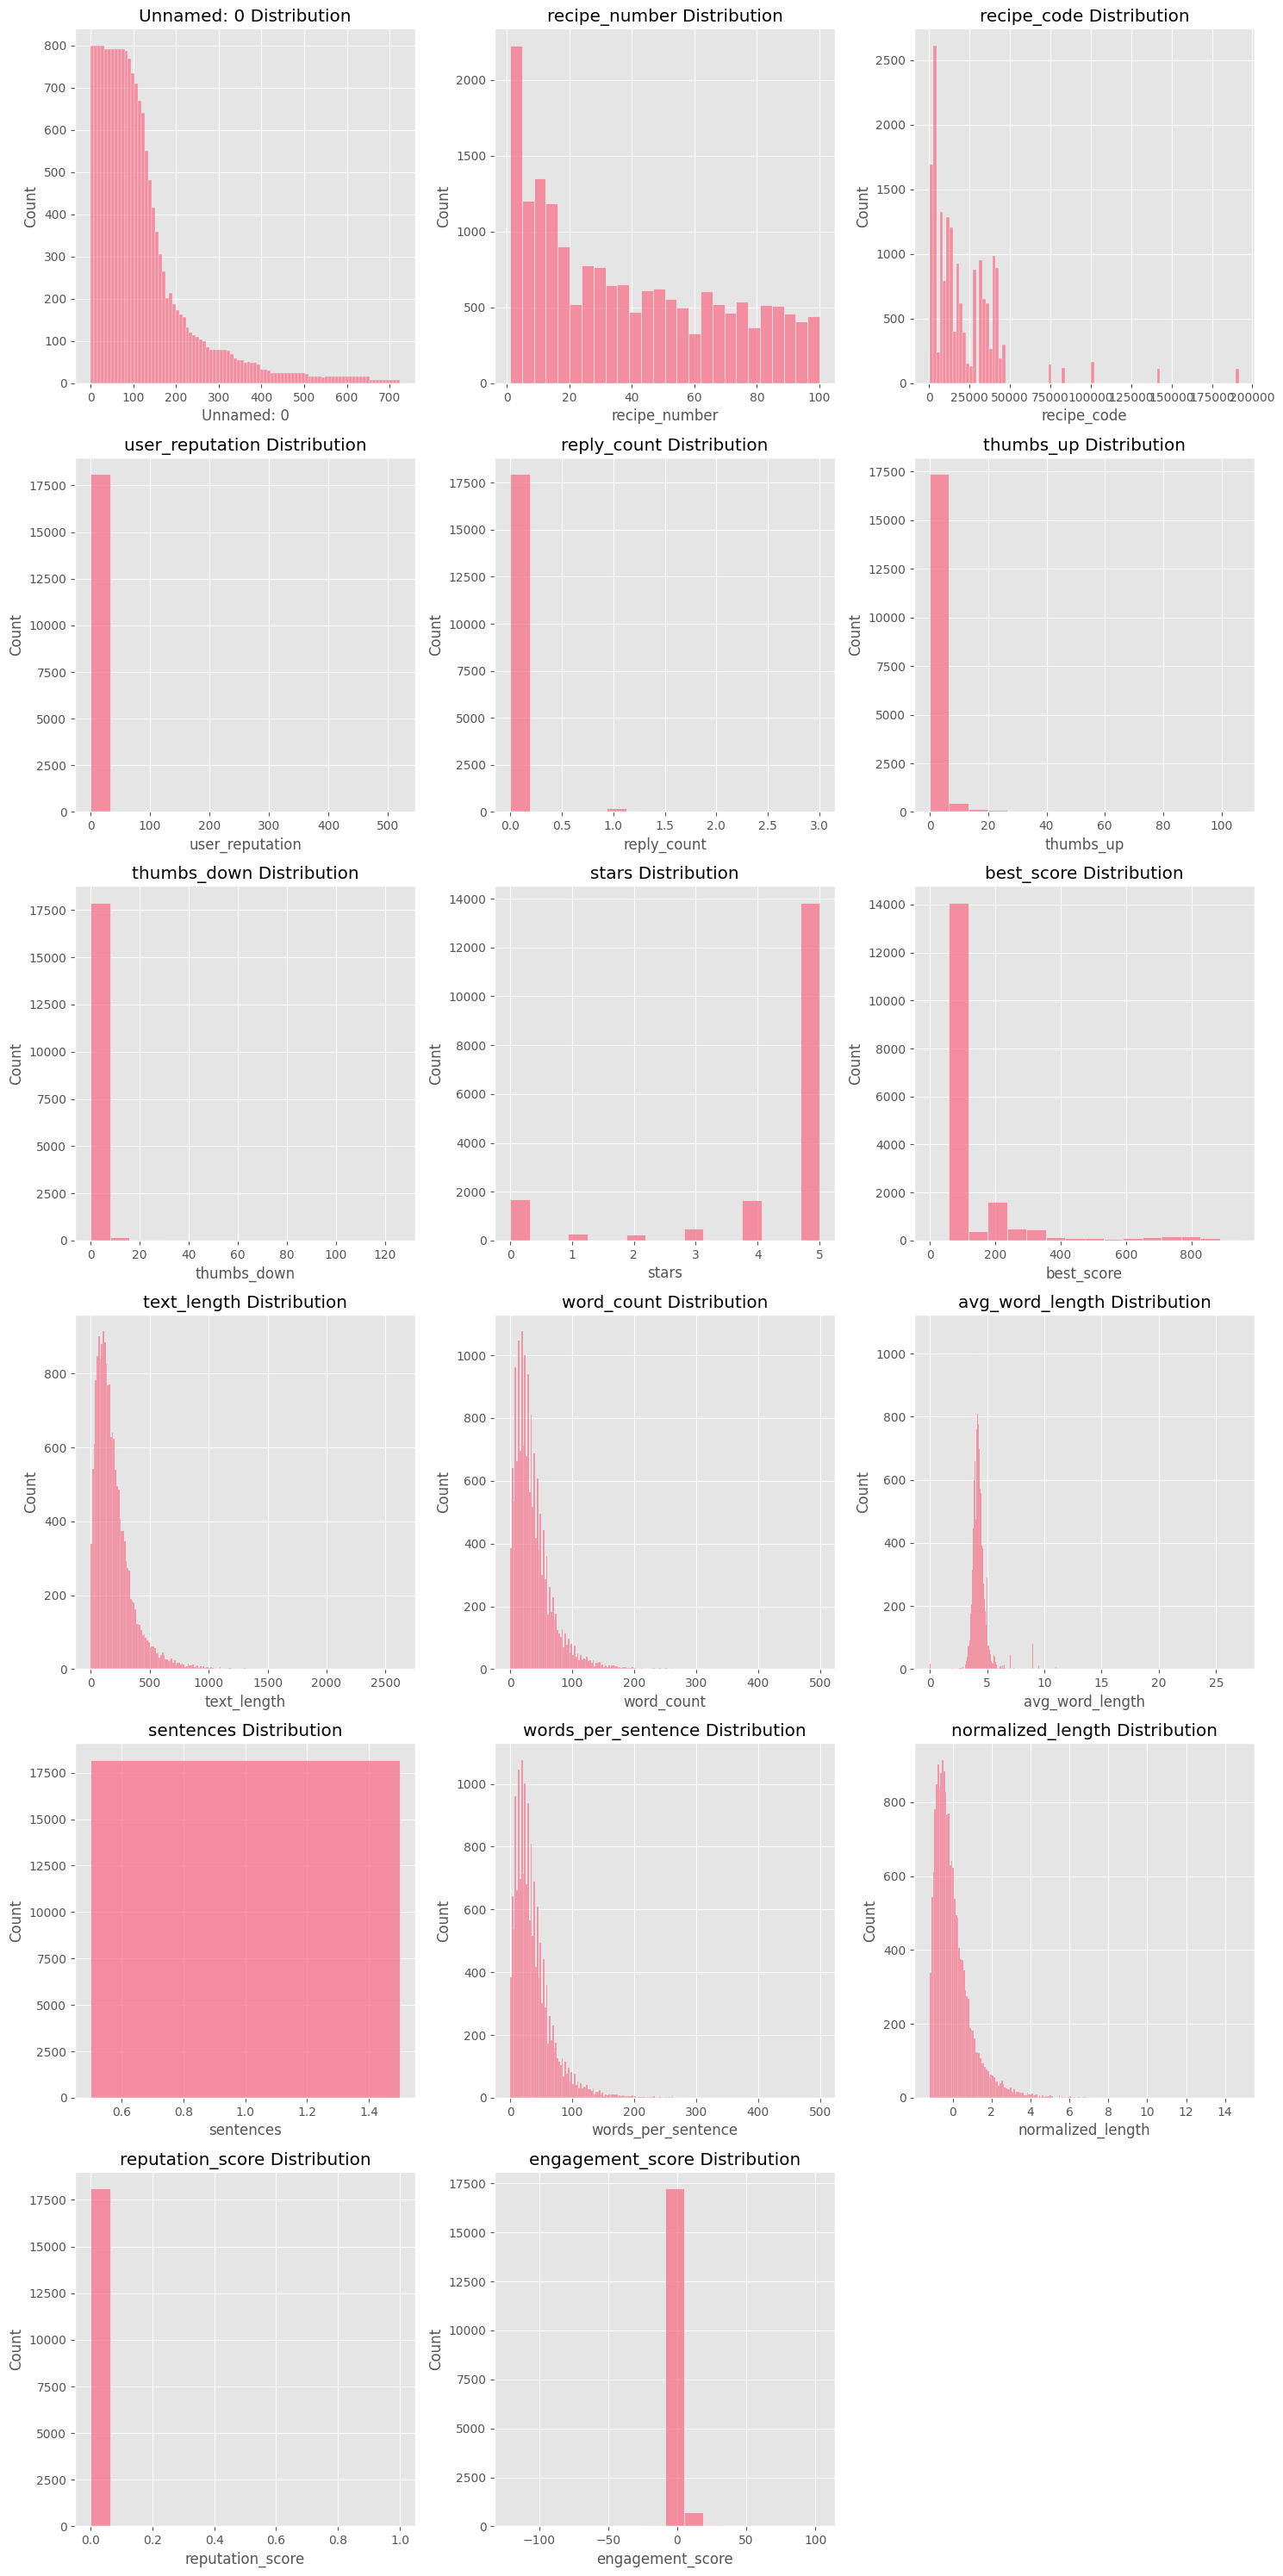


Feature Summary Statistics:
       Unnamed: 0  recipe_number  recipe_code  user_reputation  reply_count  \
count    18182.00       18182.00     18182.00         18182.00     18182.00   
mean       121.47          38.69     21773.67             2.16         0.01   
std        116.75          29.79     23965.11            10.01         0.14   
min          0.00           1.00       386.00             0.00         0.00   
25%         45.00          12.00      6086.00             1.00         0.00   
50%         91.00          33.00     14600.00             1.00         0.00   
75%        150.00          64.00     33121.00             1.00         0.00   
max        724.00         100.00    191775.00           520.00         3.00   

       thumbs_up  thumbs_down     stars  best_score  text_length  word_count  \
count   18182.00     18182.00  18182.00    18182.00     18182.00    18182.00   
mean        1.09         0.55      4.29      153.16       194.39       37.67   
std         4.20   

In [42]:
# Cell 10: Analyze Engineered Features
def analyze_features(df: pd.DataFrame, config: Config) -> None:
    """
    Analyze and visualize engineered features.
    
    Args:
        df: DataFrame with engineered features
        config: Project configuration
    """
    # Select only numeric columns
    numeric_df = df.select_dtypes(include=['float64', 'int64'])
    
    # Create correlation matrix
    plt.figure(figsize=(12, 8))
    correlation_matrix = numeric_df.corr()
    sns.heatmap(correlation_matrix, 
                annot=True, 
                cmap='coolwarm', 
                center=0, 
                fmt='.2f')
    plt.title('Feature Correlations')
    plt.tight_layout()
    plt.savefig(f"{config.FIGURES_PATH}feature_correlations.png")
    plt.show()
    
    # Feature distributions
    numeric_columns = numeric_df.columns
    n_cols = len(numeric_columns)
    n_rows = (n_cols + 2) // 3  # Ceiling division
    
    fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5 * n_rows))
    axes = axes.ravel()
    
    for idx, feature in enumerate(numeric_columns):
        if idx < len(axes):
            sns.histplot(data=numeric_df, x=feature, ax=axes[idx])
            axes[idx].set_title(f'{feature} Distribution')
    
    # Hide empty subplots if any
    for idx in range(len(numeric_columns), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.savefig(f"{config.FIGURES_PATH}feature_distributions.png")
    plt.show()
    
    # Print summary statistics
    print("\nFeature Summary Statistics:")
    print(numeric_df.describe().round(2))

# Run feature analysis
analyze_features(df_engineered, config)

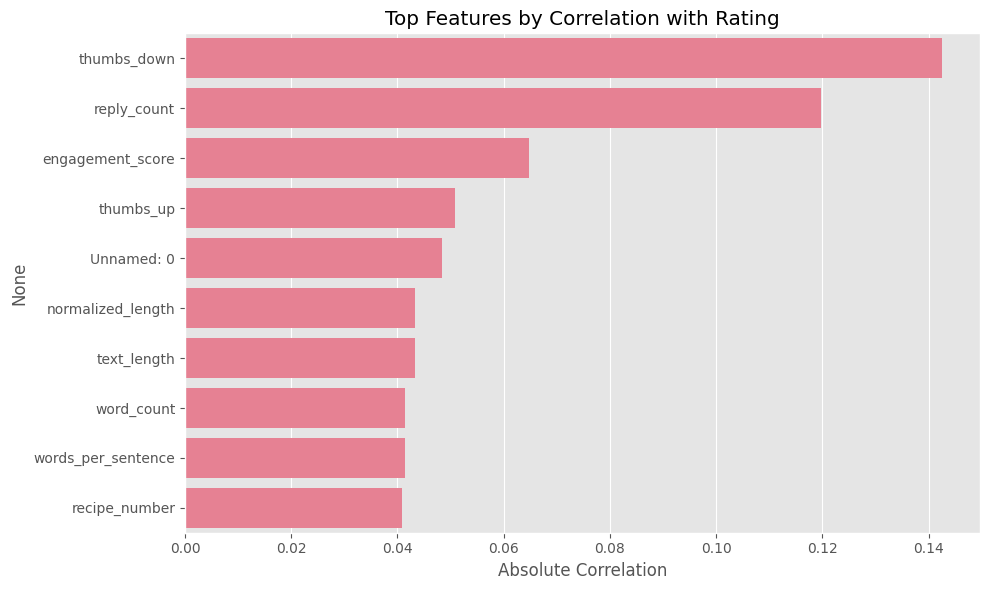


Top Features by Importance:
thumbs_down: 0.143
reply_count: 0.120
engagement_score: 0.065
thumbs_up: 0.051
Unnamed: 0: 0.048
normalized_length: 0.043
text_length: 0.043
word_count: 0.041
words_per_sentence: 0.041
recipe_number: 0.041


In [43]:
# Cell 11: Feature Selection and Importance Analysis
def analyze_feature_importance(df: pd.DataFrame, config: Config) -> pd.DataFrame:
    """
    Analyze feature importance and select most relevant features.
    
    Args:
        df: DataFrame with engineered features
        config: Project configuration
        
    Returns:
        DataFrame with selected features
    """
    # Select only numeric columns
    numeric_df = df.select_dtypes(include=['float64', 'int64'])
    
    # Calculate correlation with target
    correlations = numeric_df.corr()['stars'].abs().sort_values(ascending=False)
    
    # Select top features (excluding target)
    top_features = correlations[correlations.index != 'stars'][:10]
    
    # Visualize top feature correlations
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_features.values, y=top_features.index)
    plt.title('Top Features by Correlation with Rating')
    plt.xlabel('Absolute Correlation')
    plt.tight_layout()
    plt.savefig(f"{config.FIGURES_PATH}feature_importance.png")
    plt.show()
    
    # Print feature importance summary
    print("\nTop Features by Importance:")
    for feat, corr in top_features.items():
        print(f"{feat}: {corr:.3f}")
    
    return top_features

# Analyze feature importance
top_features = analyze_feature_importance(df_engineered, config)

In [44]:
# Cell 12: Save Feature Analysis Results
def save_feature_analysis(df: pd.DataFrame, 
                         top_features: pd.Series, 
                         config: Config) -> None:
    """
    Save feature analysis results to JSON.
    
    Args:
        df: DataFrame with engineered features
        top_features: Series of top features and their importance
        config: Project configuration
    """
    # Select only numeric columns for statistics
    numeric_df = df.select_dtypes(include=['float64', 'int64'])
    
    analysis_results = {
        'feature_stats': numeric_df[top_features.index].describe().round(2).to_dict(),
        'top_features': top_features.to_dict(),
        'total_features': len(df.columns),
        'numerical_features': len(numeric_df.columns),
        'categorical_features': len(df.select_dtypes(include=['object', 'bool']).columns)
    }
    
    # Save to JSON
    results_path = f"{config.EVAL_PATH}feature_analysis.json"
    with open(results_path, 'w') as f:
        json.dump(analysis_results, f, indent=4)
    print(f"Saved feature analysis results to {results_path}")

# Save analysis results
save_feature_analysis(df_engineered, top_features, config)

Saved feature analysis results to ../reports/model_evaluations/Task_3/feature_analysis.json


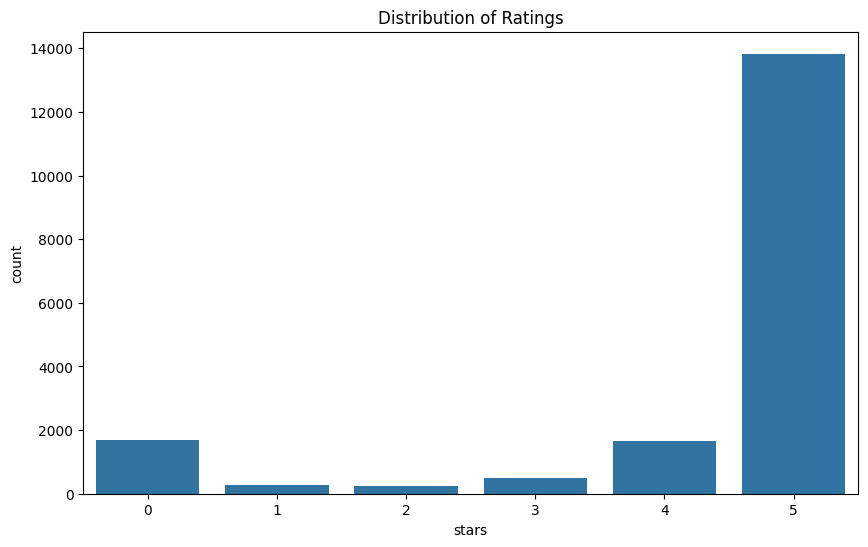

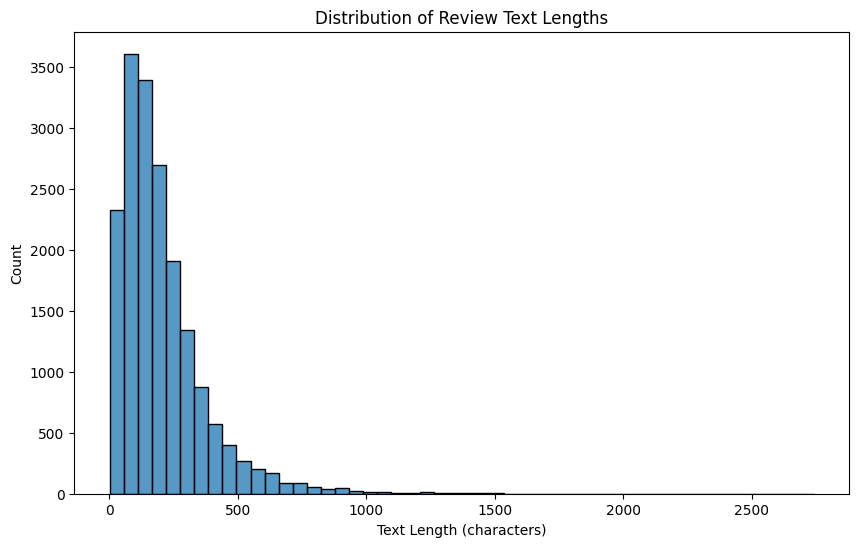


Text Length Statistics:
count    18182.000000
mean       203.894236
std        172.472595
min          1.000000
25%         90.000000
50%        161.000000
75%        266.000000
max       2742.000000
Name: text_length, dtype: float64


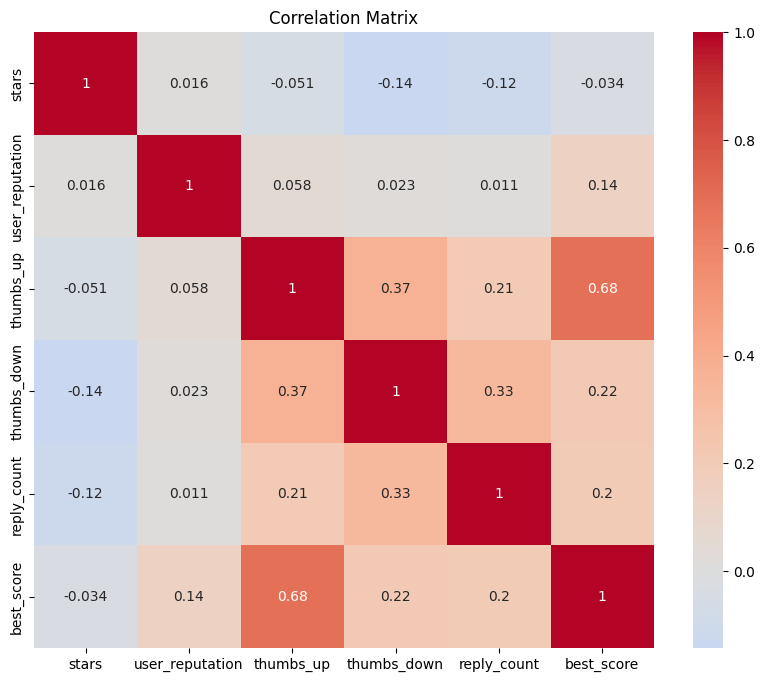

In [5]:
# Rating distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='stars')
plt.title('Distribution of Ratings')
#plt.savefig('../reports/figures/Task_3/rating_distribution.png')
plt.show()

# Text length distribution
df['text_length'] = df['text'].astype(str).apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='text_length', bins=50)
plt.title('Distribution of Review Text Lengths')
plt.xlabel('Text Length (characters)')
#plt.savefig('../reports/figures/Task_3/text_length_distribution.png')
plt.show()

# Calculate and display text length statistics
print("\nText Length Statistics:")
print(df['text_length'].describe())

# Correlation matrix
correlation_features = ['stars', 'user_reputation', 'thumbs_up', 
                       'thumbs_down', 'reply_count', 'best_score']
correlation_matrix = df[correlation_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
#plt.savefig('../reports/figures/Task_3/correlation_matrix.png')
plt.show()

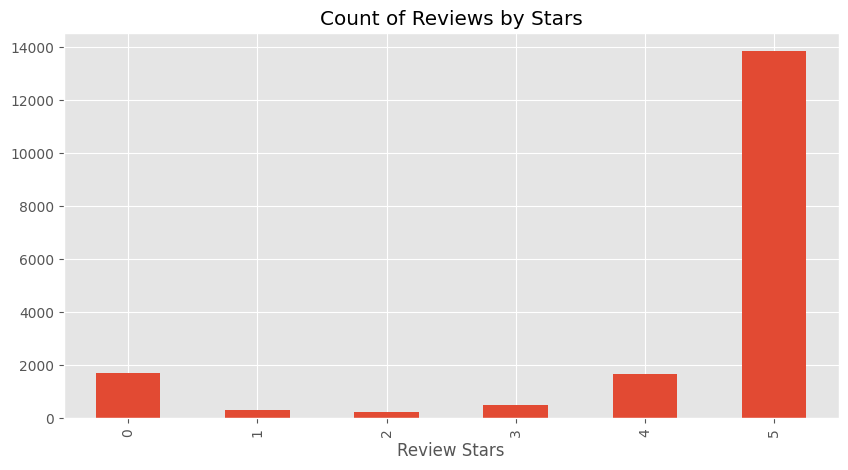

In [ ]:
# Quick EDA of ratings distribution
plt.figure(figsize=(10, 5))
ax = df['stars'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars')
ax.set_xlabel('Review Stars')
plt.savefig('../reports/figures/Task_3/rating_distribution.png')
plt.show()

In [8]:
# Take a sample review
example = df['text'].iloc[50]
print("Sample Review:")
print(example)

# Basic tokenization
tokens = nltk.word_tokenize(example)
print("\nFirst 10 tokens:")
print(tokens[:10])

Sample Review:
We have been making this for years now and its hands down our favorite chili recipe.  One thing I love about it is that you can substitute low fat versions of the cream/sour cream and its still just as good.  I&#39;ve even used skim milk in place of the whipping cream with no problems!   We always serve it with the  Zucchini &amp; Cheese Drop biscuits.  To die for!

First 10 tokens:
['We', 'have', 'been', 'making', 'this', 'for', 'years', 'now', 'and', 'its']


Sample Review:
We have been making this for years now and its hands down our favorite chili recipe.  One thing I love about it is that you can substitute low fat versions of the cream/sour cream and its still just as good.  I&#39;ve even used skim milk in place of the whipping cream with no problems!   We always serve it with the  Zucchini &amp; Cheese Drop biscuits.  To die for!

VADER Scores:
{'neg': 0.164, 'neu': 0.714, 'pos': 0.122, 'compound': -0.3578}

Analyzing reviews with VADER...


100%|██████████| 18182/18182 [00:06<00:00, 2608.65it/s]


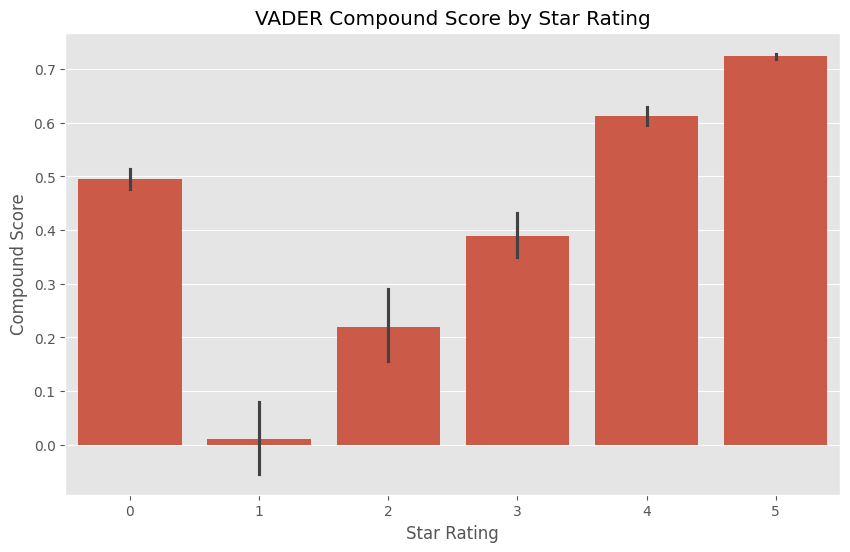

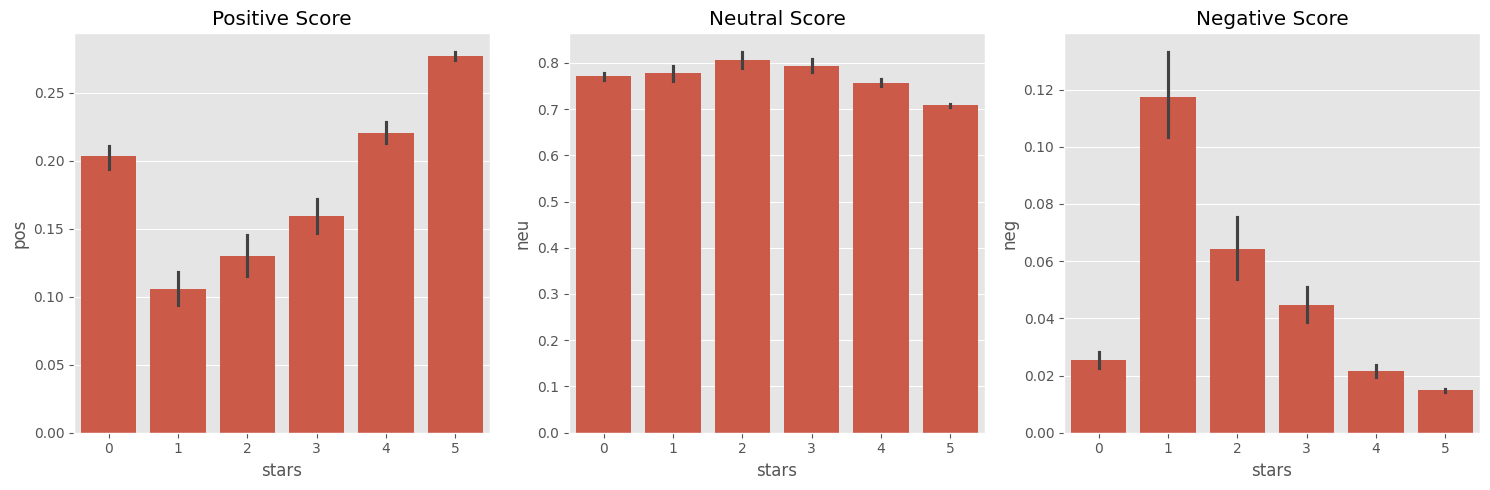

In [11]:
# Initialize VADER
sia = SentimentIntensityAnalyzer()

# Test VADER on our example
print("Sample Review:")
print(example)
print("\nVADER Scores:")
print(sia.polarity_scores(example))

# Run VADER on entire dataset
def get_vader_scores(df):
    """Get VADER sentiment scores for all reviews"""
    res = {}
    for i, row in tqdm(df.iterrows(), total=len(df)):
        text = str(row['text'])
        review_id = row['comment_id']
        res[review_id] = sia.polarity_scores(text)
    
    return res

# Get all scores
print("\nAnalyzing reviews with VADER...")
vader_scores = get_vader_scores(df)

# Convert to DataFrame
vader_df = pd.DataFrame(vader_scores).T
vader_df = vader_df.reset_index().rename(columns={'index': 'comment_id'})

# Merge with original data
df_with_vader = df.merge(vader_df, on='comment_id')

# Plot VADER results
plt.figure(figsize=(10, 6))
sns.barplot(data=df_with_vader, x='stars', y='compound')
plt.title('VADER Compound Score by Star Rating')
plt.xlabel('Star Rating')
plt.ylabel('Compound Score')
plt.savefig('../reports/figures/Task_3/vader_scores_by_stars.png')
plt.show()

# Plot detailed VADER components
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.barplot(data=df_with_vader, x='stars', y='pos', ax=axs[0])
sns.barplot(data=df_with_vader, x='stars', y='neu', ax=axs[1])
sns.barplot(data=df_with_vader, x='stars', y='neg', ax=axs[2])
axs[0].set_title('Positive Score')
axs[1].set_title('Neutral Score')
axs[2].set_title('Negative Score')
plt.tight_layout()
plt.savefig('../reports/figures/Task_3/vader_detailed_scores.png')
plt.show()

In [12]:
# Setup RoBERTa
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# Test RoBERTa on our example
def get_roberta_scores(text):
    """Get RoBERTa sentiment scores for a text"""
    encoded_text = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    
    return {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }

# Test on example
print("RoBERTa Scores for sample review:")
print(get_roberta_scores(example))

c:\Users\geova\.conda\envs\deep_learning\lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\geova\.cache\huggingface\hub\models--cardiffnlp--twitter-roberta-base-sentiment. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


RoBERTa Scores for sample review:
{'roberta_neg': 0.0023200775, 'roberta_neu': 0.010731087, 'roberta_pos': 0.98694885}


In [13]:
# Process all reviews with RoBERTa
def analyze_full_dataset_roberta(df):
    """Analyze all reviews with RoBERTa"""
    results = []
    
    print("Analyzing reviews with RoBERTa...")
    for i, row in tqdm(df.iterrows(), total=len(df)):
        text = str(row['text'])
        try:
            scores = get_roberta_scores(text)
            scores['comment_id'] = row['comment_id']
            results.append(scores)
        except Exception as e:
            print(f"Error processing review {row['comment_id']}: {e}")
    
    return pd.DataFrame(results)

# Get RoBERTa scores
roberta_df = analyze_full_dataset_roberta(df)

# Merge with previous results
df_complete = df_with_vader.merge(roberta_df, on='comment_id')

Analyzing reviews with RoBERTa...


100%|██████████| 18182/18182 [15:23<00:00, 19.70it/s]


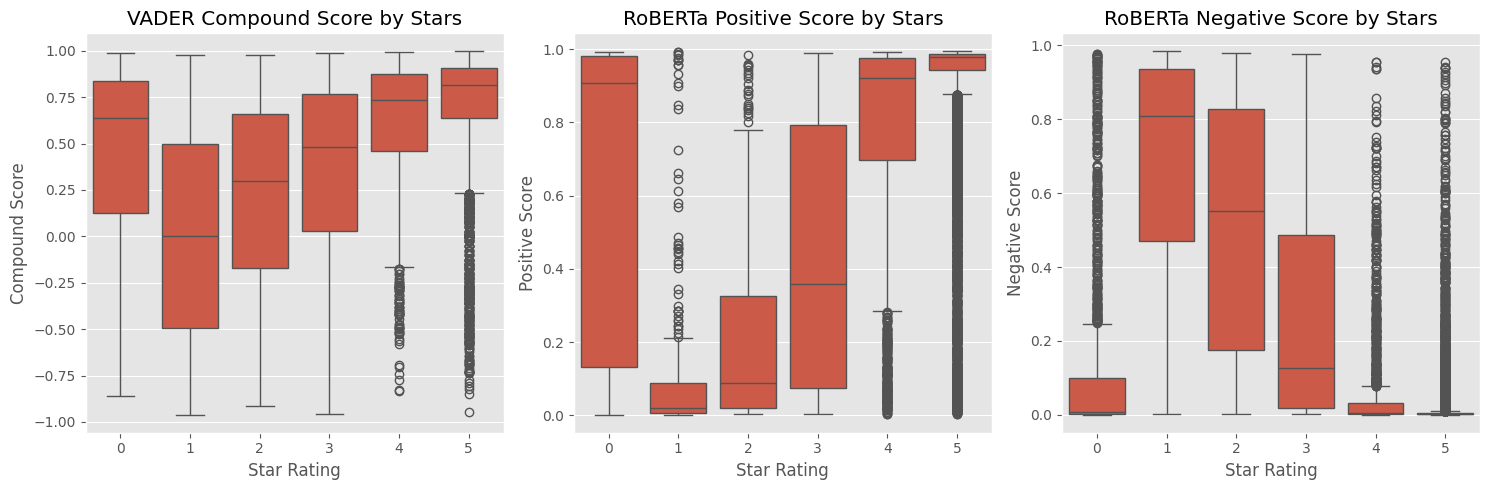

In [14]:
# Create comparison visualizations
plt.figure(figsize=(15, 5))

# Plot 1: VADER Compound vs Stars
plt.subplot(131)
sns.boxplot(data=df_complete, x='stars', y='compound')
plt.title('VADER Compound Score by Stars')
plt.xlabel('Star Rating')
plt.ylabel('Compound Score')

# Plot 2: RoBERTa Positive vs Stars
plt.subplot(132)
sns.boxplot(data=df_complete, x='stars', y='roberta_pos')
plt.title('RoBERTa Positive Score by Stars')
plt.xlabel('Star Rating')
plt.ylabel('Positive Score')

# Plot 3: RoBERTa Negative vs Stars
plt.subplot(133)
sns.boxplot(data=df_complete, x='stars', y='roberta_neg')
plt.title('RoBERTa Negative Score by Stars')
plt.xlabel('Star Rating')
plt.ylabel('Negative Score')

plt.tight_layout()
plt.savefig('../reports/figures/Task_3/vader_roberta_comparison.png')
plt.show()

In [15]:
def find_interesting_cases(df):
    """Find cases where models disagree significantly"""
    
    # Convert VADER compound to sentiment direction
    vader_sentiment = df['compound'].apply(lambda x: 1 if x > 0.05 else (-1 if x < -0.05 else 0))
    
    # Get RoBERTa sentiment direction
    roberta_sentiment = df.apply(
        lambda x: 1 if x['roberta_pos'] > max(x['roberta_neg'], x['roberta_neu'])
        else (-1 if x['roberta_neg'] > max(x['roberta_pos'], x['roberta_neu'])
        else 0), axis=1
    )
    
    # Find disagreements
    disagreements = df[vader_sentiment != roberta_sentiment].copy()
    
    # Sort by the magnitude of disagreement
    disagreements['disagreement_magnitude'] = abs(df['compound']) + \
        df[['roberta_neg', 'roberta_neu', 'roberta_pos']].max(axis=1)
    
    return disagreements.sort_values('disagreement_magnitude', ascending=False)

# Find and display interesting cases
interesting_cases = find_interesting_cases(df_complete)
print("\nTop 5 cases where VADER and RoBERTa disagree:")
for i, row in interesting_cases.head().iterrows():
    print("\nReview Text:")
    print(row['text'][:200], "...")
    print(f"\nStar Rating: {row['stars']}")
    print(f"VADER Compound: {row['compound']:.3f}")
    print(f"RoBERTa Scores: Neg={row['roberta_neg']:.3f}, Neu={row['roberta_neu']:.3f}, Pos={row['roberta_pos']:.3f}")
    print("-"*80)


Top 5 cases where VADER and RoBERTa disagree:

Review Text:
didn&#39;t like it - too creamy, too rich - i didn&#39;t feel good after having it.  sour cream &amp; whipping cream is overkill. would&#39;ve been better with just whipping cream. ...

Star Rating: 1
VADER Compound: 0.898
RoBERTa Scores: Neg=0.902, Neu=0.085, Pos=0.014
--------------------------------------------------------------------------------

Review Text:
Exple, thanks for the dumpling recipe!  I really don&#39;t like the ones made with bisquick any more ....  and Stewart and Lolygagtx .... you&#39;re talking about cooked pie dough and those are the mo ...

Star Rating: 5
VADER Compound: 0.870
RoBERTa Scores: Neg=0.928, Neu=0.057, Pos=0.016
--------------------------------------------------------------------------------

Review Text:
I dislike coffee flavor of any kind.  Could I substitute water?  I know coffee is supposed to enhance the flavor of chocolate, but yuck....I LOVE chocolate but can&#39;t even take mocha. 

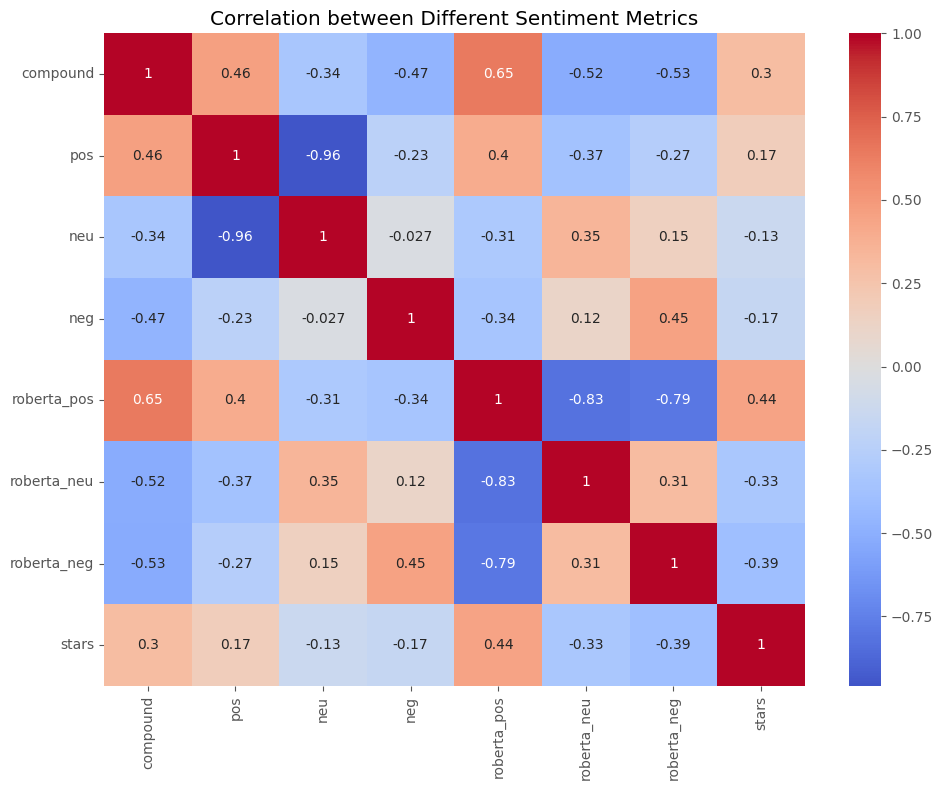

In [16]:
# Calculate correlations between different sentiment scores
sentiment_cols = ['compound', 'pos', 'neu', 'neg', 
                 'roberta_pos', 'roberta_neu', 'roberta_neg', 'stars']
correlation_matrix = df_complete[sentiment_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between Different Sentiment Metrics')
plt.tight_layout()
plt.savefig('../reports/figures/Task_3/sentiment_correlations.png')
plt.show()

In [6]:
import re

def clean_text(text):
    """Clean text data"""
    if pd.isna(text):
        return ""
    
    text = str(text)
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\S*@\S*\s?', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = ' '.join(text.split())
    
    return text

# Clean text and prepare data
df['cleaned_text'] = df['text'].apply(clean_text)

# Remove empty texts and 0 star reviews
df_cleaned = df[
    (df['cleaned_text'] != "") & 
    (df['stars'] != 0)
].copy()

# Create sentiment labels
SENTIMENT_MAPPING = {
    1: 0,  # Negative
    2: 0,  # Negative
    3: 1,  # Neutral
    4: 2,  # Positive
    5: 2   # Positive
}

df_cleaned['sentiment'] = df_cleaned['stars'].map(SENTIMENT_MAPPING)

print("\nFinal Dataset Shape:", df_cleaned.shape)
print("\nSentiment Distribution:")
print(df_cleaned['sentiment'].value_counts(normalize=True).round(3))


Final Dataset Shape: (16471, 18)

Sentiment Distribution:
sentiment
2    0.939
0    0.031
1    0.030
Name: proportion, dtype: float64


In [7]:
# Constants
MAX_LENGTH = 512  # Standard BERT length
MODEL_NAME = 'bert-base-uncased'
RANDOM_STATE = 42
BATCH_SIZE = 16

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [8]:
# Create train, validation, and test splits
train_df, temp_df = train_test_split(
    df_cleaned, 
    test_size=0.2, 
    random_state=RANDOM_STATE,
    stratify=df_cleaned['sentiment']
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=RANDOM_STATE,
    stratify=temp_df['sentiment']
)

print("\nDataset splits:")
print(f"Train set: {len(train_df)} reviews")
print(f"Validation set: {len(val_df)} reviews")
print(f"Test set: {len(test_df)} reviews")


Dataset splits:
Train set: 13176 reviews
Validation set: 1647 reviews
Test set: 1648 reviews


In [9]:
# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class RecipeReviewDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        text = str(self.df.iloc[idx]['cleaned_text'])
        label = self.df.iloc[idx]['sentiment']
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [17]:
# Create dataset objects
train_dataset = RecipeReviewDataset(train_df, tokenizer, MAX_LENGTH)
val_dataset = RecipeReviewDataset(val_df, tokenizer, MAX_LENGTH)
test_dataset = RecipeReviewDataset(test_df, tokenizer, MAX_LENGTH)

# Create dataloaders
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory=True
)

# Verify dataloader shapes
batch = next(iter(train_loader))
print("\nBatch shapes:")
print(f"Input IDs: {batch['input_ids'].shape}")
print(f"Attention mask: {batch['attention_mask'].shape}")
print(f"Labels: {batch['labels'].shape}")


Batch shapes:
Input IDs: torch.Size([16, 512])
Attention mask: torch.Size([16, 512])
Labels: torch.Size([16])


In [10]:
def setup_model():
    """Initialize the BERT model for sequence classification"""
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=3,  # Negative, Neutral, Positive
        problem_type="single_label_classification"
    ).to(device)
    
    return model

# Initialize model
model = setup_model()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

def setup_training(model, learning_rate=2e-5):
    """
    Setup optimizer and scheduler
    """
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(
        optimizer, 
        mode='min',
        factor=0.1,
        patience=2,
        verbose=True
    )
    
    return optimizer, scheduler

# Initialize optimizer and scheduler
optimizer, scheduler = setup_training(model)

c:\Users\geova\anaconda3\envs\deep_learning\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [12]:
def train_epoch(model, train_loader, optimizer, device):
    """
    Training loop for one epoch
    """
    model.train()
    total_loss = 0
    
    progress_bar = tqdm(train_loader, desc='Training')
    for batch in progress_bar:
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(**batch)
        loss = outputs.loss
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})
    
    return total_loss / len(train_loader)

In [13]:
from sklearn.metrics import classification_report

def evaluate(model, eval_loader, device):
    """
    Evaluation function
    """
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(eval_loader, desc='Evaluating'):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            
            loss = outputs.loss
            total_loss += loss.item()
            
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch['labels'].cpu().numpy())
    
    # Calculate metrics
    report = classification_report(
        all_labels,
        all_preds,
        target_names=['Negative', 'Neutral', 'Positive'],
        output_dict=True
    )
    
    return {
        'loss': total_loss / len(eval_loader),
        'metrics': report
    }

In [15]:
def train_model(model, train_loader, val_loader, optimizer, scheduler, 
                num_epochs=3, save_dir="../reports/model_evaluation/Task_3/"):
    """
    Main training loop with model saving and metric tracking
    """
    # Setup saving directory
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    
    # Initialize tracking variables
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    
    print(f"Starting training on {device}")
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        print("-" * 40)
        
        # Training phase
        train_loss = train_epoch(model, train_loader, optimizer, device)
        train_losses.append(train_loss)
        
        # Validation phase
        val_results = evaluate(model, val_loader, device)
        val_loss = val_results['loss']
        val_losses.append(val_loss)
        
        # Print metrics
        print(f"\nTrain Loss: {train_loss:.4f}")
        print(f"Validation Loss: {val_loss:.4f}")
        print("\nValidation Metrics:")
        for label in ['Negative', 'Neutral', 'Positive']:
            metrics = val_results['metrics'][label]
            print(f"\n{label}:")
            print(f"Precision: {metrics['precision']:.3f}")
            print(f"Recall: {metrics['recall']:.3f}")
            print(f"F1-Score: {metrics['f1-score']:.3f}")
        
        # Scheduler step
        scheduler.step(val_loss)
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            print("\nSaving best model...")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
            }, f"{save_dir}/best_model.pt")
        
        # Save metrics for this epoch
        metrics_path = f"{save_dir}/metrics_epoch_{epoch+1}.json"
        with open(metrics_path, 'w') as f:
            json.dump({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'classification_report': val_results['metrics']
            }, f, indent=4)
    
    return train_losses, val_losses



In [18]:
# Start training
print("Initializing training...")
train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler
)

Initializing training...
Starting training on cuda

Epoch 1/3
----------------------------------------


Evaluating: 100%|██████████| 103/103 [04:41<00:00,  2.73s/it]
c:\Users\geova\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\geova\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\geova\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beha


Train Loss: 0.1762
Validation Loss: 0.1376

Validation Metrics:

Negative:
Precision: 0.660
Recall: 0.647
F1-Score: 0.653

Neutral:
Precision: 0.000
Recall: 0.000
F1-Score: 0.000

Positive:
Precision: 0.966
Recall: 0.997
F1-Score: 0.982

Saving best model...

Epoch 2/3
----------------------------------------


Evaluating: 100%|██████████| 103/103 [04:40<00:00,  2.72s/it]



Train Loss: 0.1070
Validation Loss: 0.1379

Validation Metrics:

Negative:
Precision: 0.562
Recall: 0.804
F1-Score: 0.661

Neutral:
Precision: 0.667
Recall: 0.082
F1-Score: 0.145

Positive:
Precision: 0.976
Recall: 0.989
F1-Score: 0.982

Epoch 3/3
----------------------------------------


Evaluating: 100%|██████████| 103/103 [04:41<00:00,  2.73s/it]


Train Loss: 0.0731
Validation Loss: 0.1569

Validation Metrics:

Negative:
Precision: 0.743
Recall: 0.510
F1-Score: 0.605

Neutral:
Precision: 0.362
Recall: 0.429
F1-Score: 0.393

Positive:
Precision: 0.979
Recall: 0.984
F1-Score: 0.982


In [19]:
# Load best model
best_model_path = "../reports/model_evaluation/Task_3/best_model.pt"
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])

# Evaluate on test set
test_results = evaluate(model, test_loader, device)

print("\nTest Set Results:")
for label in ['Negative', 'Neutral', 'Positive']:
    print(f"\n{label}:")
    metrics = test_results['metrics'][label]
    print(f"Precision: {metrics['precision']:.3f}")
    print(f"Recall: {metrics['recall']:.3f}")
    print(f"F1-Score: {metrics['f1-score']:.3f}")

C:\Users\geova\AppData\Local\Temp\ipykernel_9704\3759206297.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path)
Evaluating: 100%|███


Test Set Results:

Negative:
Precision: 0.500
Recall: 0.608
F1-Score: 0.549

Neutral:
Precision: 0.000
Recall: 0.000
F1-Score: 0.000

Positive:
Precision: 0.971
Recall: 0.995
F1-Score: 0.983



c:\Users\geova\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\geova\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\geova\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

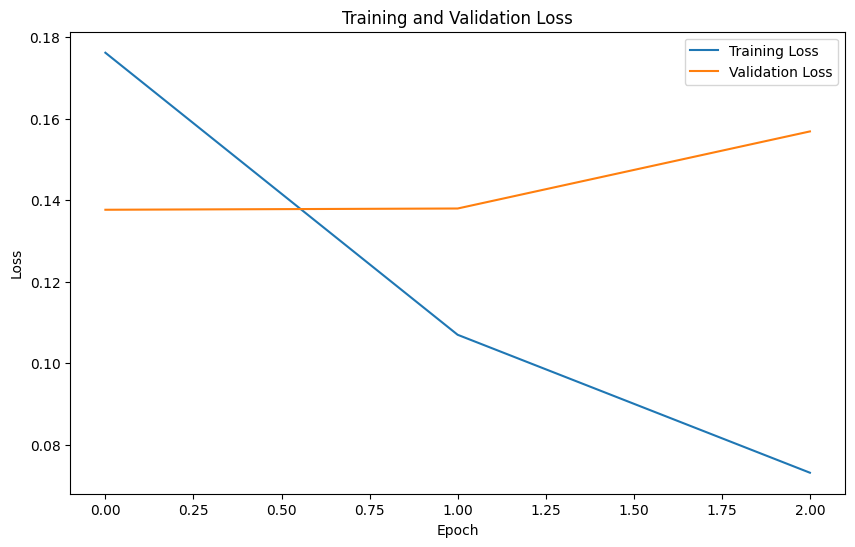

In [20]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
#plt.savefig('../reports/figures/Task_3/training_history.png')
plt.show()